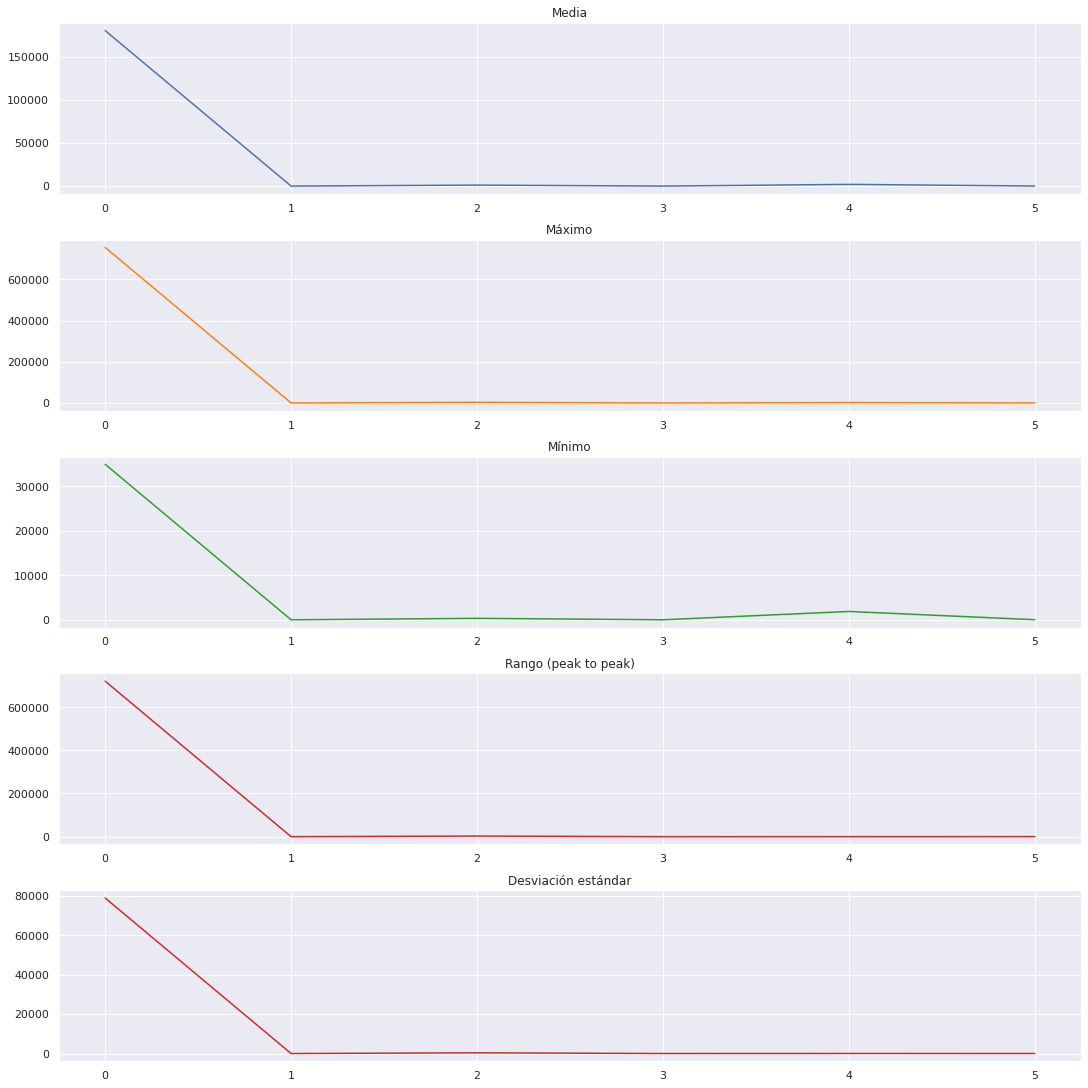

In [99]:
##Carga de librerias
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sbn
import matplotlib.pyplot as plt

#Carga de dataset y división de dataset
data = np.load('proyecto_training_data.npy')
training_data = data[:1168]
test_data = data[1168:]

#Análisis exploratorio de datos
mean_training_data = np.nanmean(training_data,axis=0)
max_training_data = np.nanmax(training_data,axis=0)
min_training_data = np.nanmin(training_data,axis=0)
ptp_training_data = np.nanmax(training_data,axis=0) - np.nanmin(training_data,axis=0)
std_traning_data = np.nanstd(training_data,axis=0)

fig, axs = plt.subplots(5, 1,constrained_layout = True)
axs[0].plot(mean_training_data)
axs[0].set_title('Media')
axs[1].plot(max_training_data, 'tab:orange')
axs[1].set_title('Máximo')
axs[2].plot(min_training_data, 'tab:green')
axs[2].set_title('Mínimo')
axs[3].plot(ptp_training_data, 'tab:red')
axs[3].set_title('Rango (peak to peak)')
axs[4].plot(std_traning_data, 'tab:red')
axs[4].set_title('Desviación estándar')
fig.set_size_inches(15, 15)
plt.show()



Debido a que la primera variable cuenta con valores mucho mayores que las otras, se realiza un análisis de las otras 5 variables.



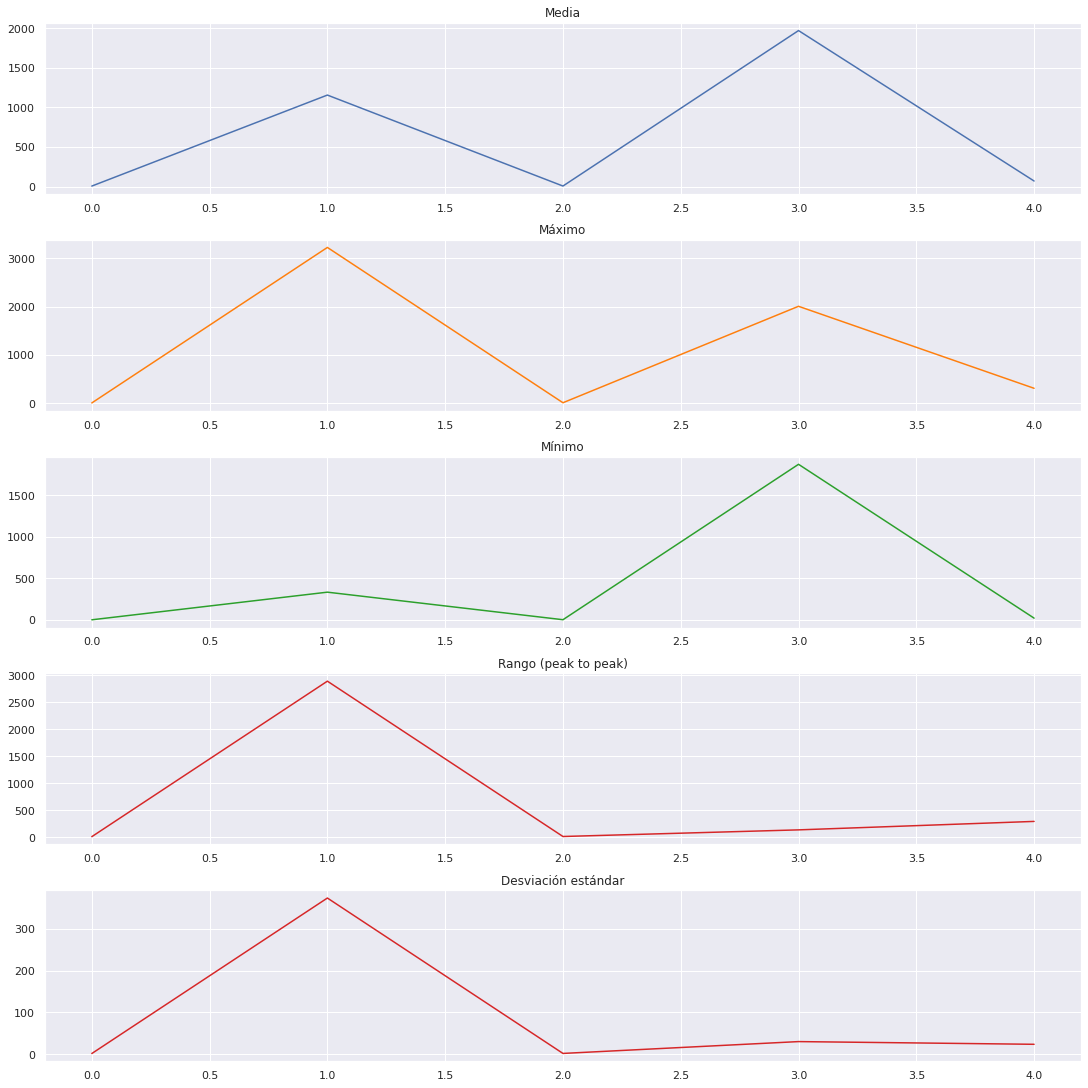

In [100]:
fig, axs = plt.subplots(5, 1,constrained_layout = True)
axs[0].plot(mean_training_data[1:])
axs[0].set_title('Media')
axs[1].plot(max_training_data[1:], 'tab:orange')
axs[1].set_title('Máximo')
axs[2].plot(min_training_data[1:], 'tab:green')
axs[2].set_title('Mínimo')
axs[3].plot(ptp_training_data[1:], 'tab:red')
axs[3].set_title('Rango (peak to peak)')
axs[4].plot(std_traning_data[1:], 'tab:red')
axs[4].set_title('Desviación estándar')
fig.set_size_inches(15, 15)
plt.show()

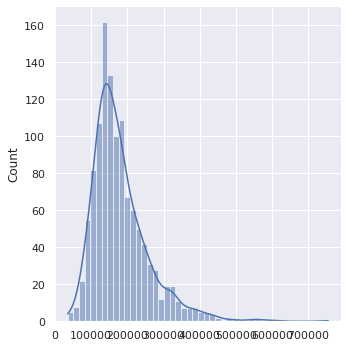

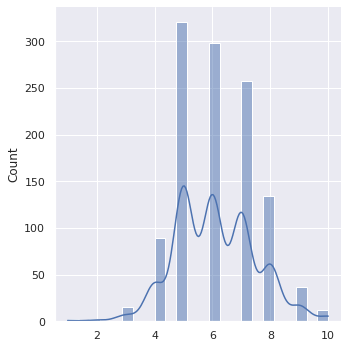

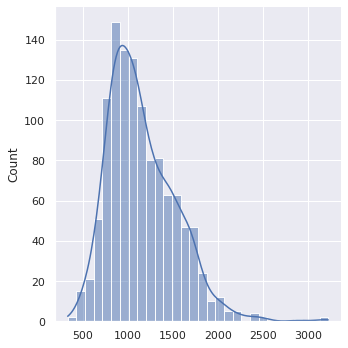

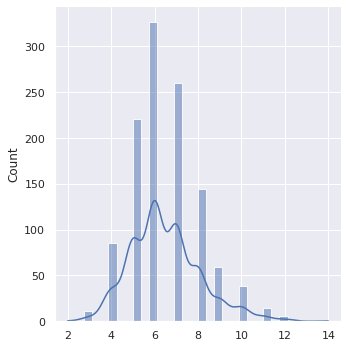

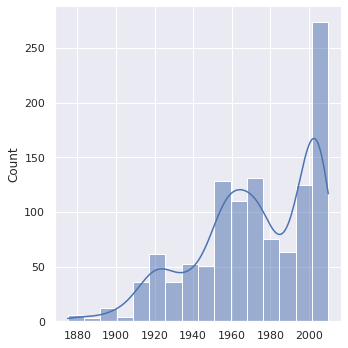

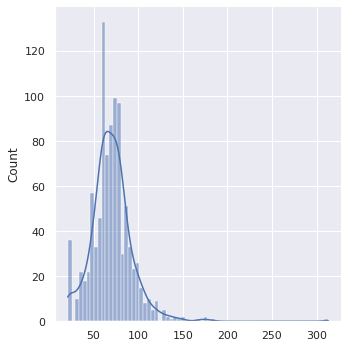

In [101]:
#Obtener variables 
x1 = training_data[:, 0]
x2 = training_data[:, 1]
x3 = training_data[:, 2]
x4 = training_data[:, 3]
x5 = training_data[:, 4]
x6 = training_data[:, 5]

sbn.set_theme(); 
ax = sbn.displot(x1, kde=True)
ax = sbn.displot(x2, kde=True)
ax = sbn.displot(x3, kde=True)
ax = sbn.displot(x4, kde=True)
ax = sbn.displot(x5, kde=True)
ax = sbn.displot(x6, kde=True)

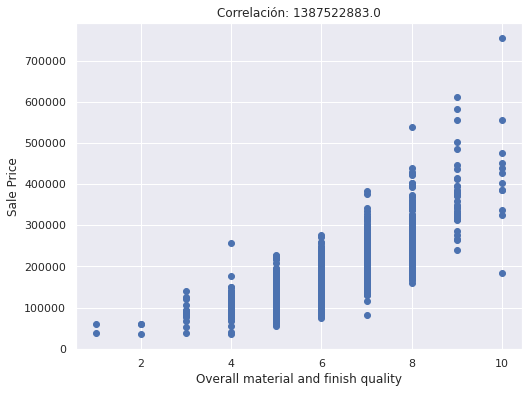

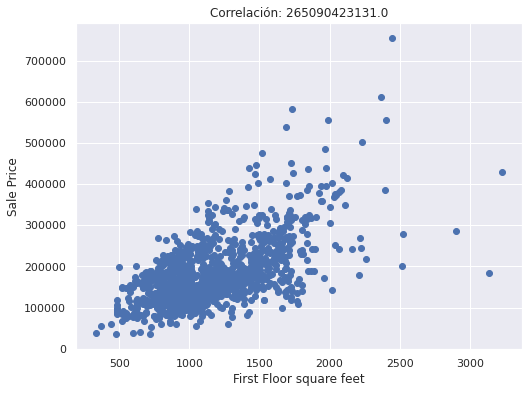

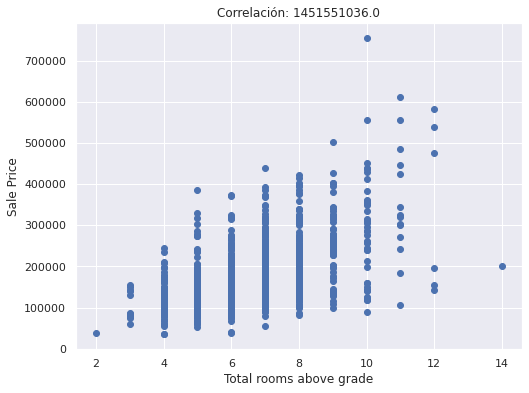

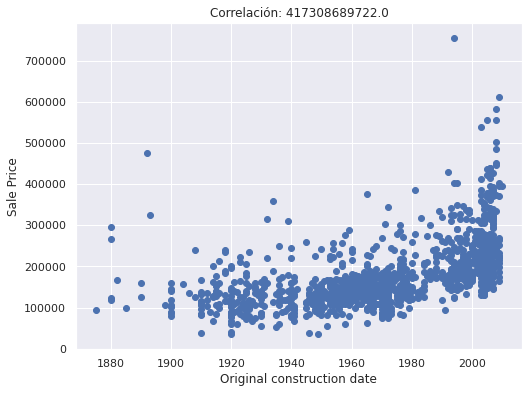

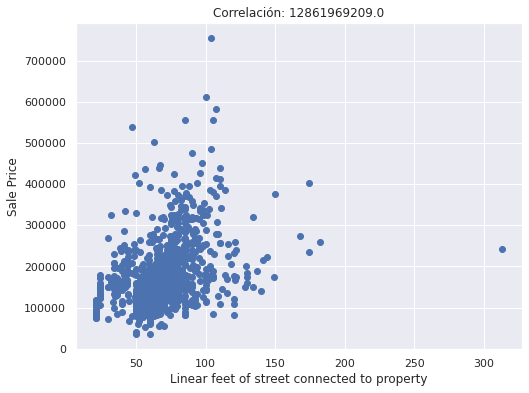

In [102]:
plt.rcParams['figure.figsize'] = 8, 6
plt.scatter(x2,x1)
plt.xlabel('Overall material and finish quality')
plt.ylabel('Sale Price')
plt.title('Correlación: '  + str(np.dot(x1,x2)))
plt.show()
plt.scatter(x3,x1)
plt.title('Correlación: '  + str(np.dot(x1,x3)))
plt.ylabel('Sale Price')
plt.xlabel('First Floor square feet')
plt.show()
plt.scatter(x4,x1)
plt.title('Correlación: '  + str(np.dot(x1,x4)))
plt.ylabel('Sale Price')
plt.xlabel('Total rooms above grade')
plt.show()
plt.scatter(x5,x1)
plt.title('Correlación: '  + str(np.dot(x1,x5)))
plt.ylabel('Sale Price')
plt.xlabel('Original construction date')
plt.show()
plt.scatter(x6,x1)
plt.title('Correlación: '  + str(np.nansum(x1*x6)))
plt.ylabel('Sale Price')
plt.xlabel('Linear feet of street connected to property')
plt.show()

correlacion = {'x2': np.dot(x1,x2),'x3': np.dot(x1,x3),'x4': np.dot(x1,x4),'x5': np.dot(x1,x5), 'x6': np.nansum(x1*x6)}
mejorCorrelacion = sorted(correlacion.items(), key=lambda x: x[1], reverse=True)

In [103]:
##Seleccionando variables
correlacion = {'x2': np.dot(x1,x2),'x3': np.dot(x1,x3),'x4': np.dot(x1,x4),'x5': np.dot(x1,x5), 'x6': np.nansum(x1*x6)}
mejorCorrelacion = sorted(correlacion.items(), key=lambda x: x[1], reverse=True)
print(mejorCorrelacion[:2])


[('x5', 417308689722.0), ('x3', 265090423131.0)]


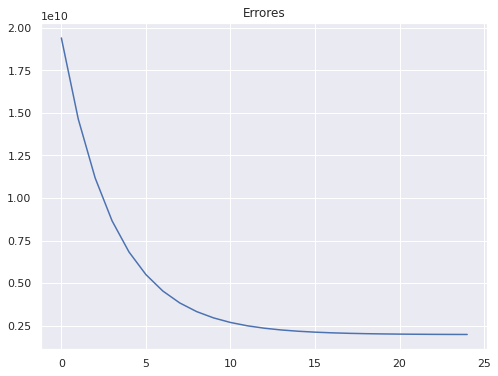

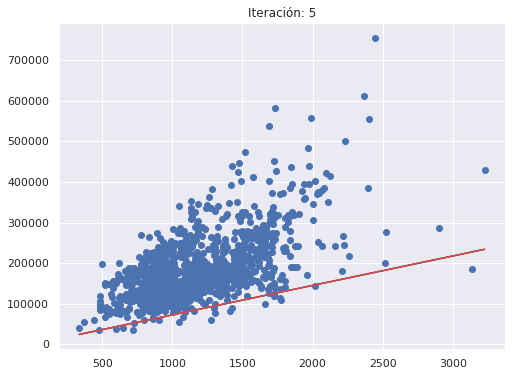

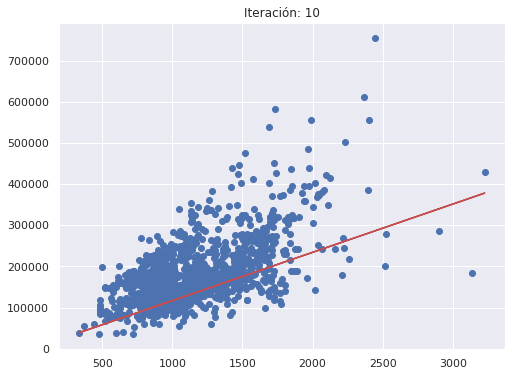

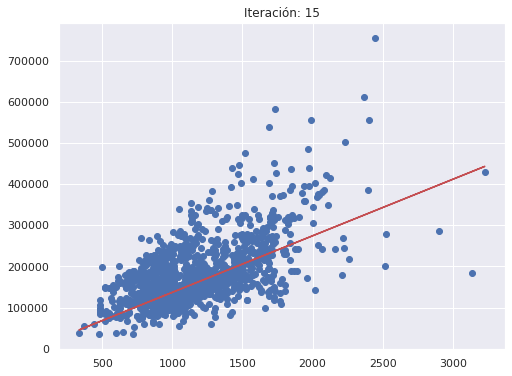

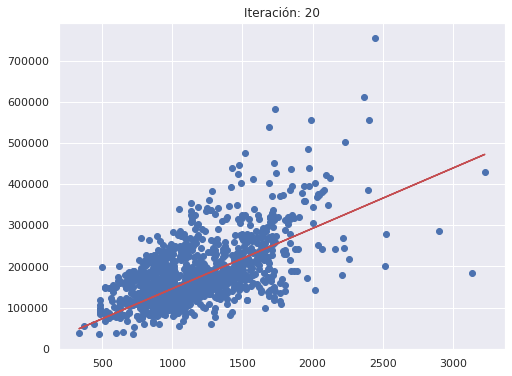

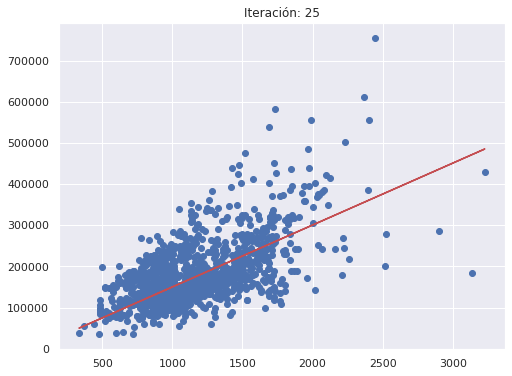

In [113]:
#Definición de la función para cálculo manual

def regresionManual(x,y,epoch,imprimir_error_cada, lr, param=[0,0]):
  errores = []
  ones = np.ones_like(x)
  matriz = np.stack((x,ones),axis=-1)
  dic = {}
  for a in range(0, epoch):
    dic[a+1] = np.array(param)
    yhat = np.matmul(matriz,param)
    dic[a+1] = [np.array(param),yhat]
    error = 0.5* np.mean(np.power((yhat-y),2))
    errores.append(error)
    restayhaty = yhat-y
    matrizGradientes = matriz * restayhaty.reshape(len(restayhaty),1)
    matrizGradientes = matrizGradientes.mean(axis=0)
    param = param - (lr * matrizGradientes)
    if(imprimir_error_cada > 0):
      if (a+1) % imprimir_error_cada == 0:
        print(error)
    
  return dic, errores

def plotErrores(Errores):
  plt.title('Errores')
  plt.plot(Errores)
  plt.show()

def plotModeloEntrenado(resultadoDic, n, training_data, salePrice):
  for (key,value) in resultadoDic.items():
    if(key%n) == 0:
      plt.scatter(training_data, salePrice, marker='o')
      plt.plot(training_data, value[1],color="r")
      plt.title('Iteración: ' + str(key))
      plt.show();
  

resultadoDic, resultadoErrores = regresionManual(x3,x1,25,50,0.0000001,[0,0])
plotErrores(resultadoErrores)

plotModeloEntrenado(resultadoDic, 5, x3,x1)




In [115]:
#Regresión con scikit-learn

def regresionsklearn(x,y):
  x = x.reshape(-1,1)
  y = y.reshape(-1,1)
  reg = LinearRegression()
  reg.fit(x,y)
  y_pred = reg.predict(x)
  return y_pred

  def regresionLineal(x,y, epoch, lr, param=[0,0]):
    dicyrm, errores = regresionManual(x,y,epoch,0,lr,param)
    y_rm = dicyrm[epoch][1].reshape(len(dicyrm[epoch][1]),1)
    y_predsk = regresionsklearn(x,y)
    matrix = np.hstack((y_rm,y_predsk))
    matrix = matrix.mean(axis=1)
    return y_rm, y_predsk, matrix

#Calcular para las variables independientes modelo manual y modelo sklearn y obtener promedio
y1_m, y1_sk, y1_mean = regresionLineal(x5,x1,100,0.00000001,[0,0])
y2_m, y2_sk, y2_mean = regresionLineal(x3,x1,25,0.0000001,[0,0])